In [1]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras

from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
from keras_unet_collection import layer_utils as k_layers
from keras_unet_collection.activations import GELU

2022-09-02 19:37:51.977165: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

def verif_metric(VALID_target, Y_pred, thres=0.5):

    tn, fp, fn, tp = confusion_matrix(VALID_target.ravel(), Y_pred.ravel()>thres).ravel()

    CSI = tp/(tp+fn+fp)
    CSI_metric = 1 - CSI
    
    POFD = fp/(tn+fp)
    
    fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    AUC = auc(fpr, tpr)
    AUC_metric = 1 - AUC
    
    freq = (tp+fp)/(tp+fn)
    freq_metric = np.abs(freq-1.0)
    
    print('{} {} {} {}'.format(CSI, POFD, AUC, freq))
    metric = CSI_metric


    return metric

In [4]:
L_vars = 19

In [5]:
filename_neg_storm = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*.npy"))
#filename_neg_calm = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*calm*.npy"))
# filename_neg_wind = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*wind*.npy"))
# filename_neg_hail = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*hail*.npy"))
filename_aug = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_aug/*.npy"))

In [6]:
with h5py.File(save_dir_scratch+'VALID_real_lead{}.hdf'.format(21), 'r') as h5io:
    TEST_input = h5io['TEST_input'][...]
    TEST_target = h5io['TEST_target'][...]

TEST_target[np.isnan(TEST_target)] = 0.0
TEST_target[TEST_target!=0] = 1.0

TEST_input = TEST_input[9000:15000, ...]
TEST_target = TEST_target[9000:15000, ...]

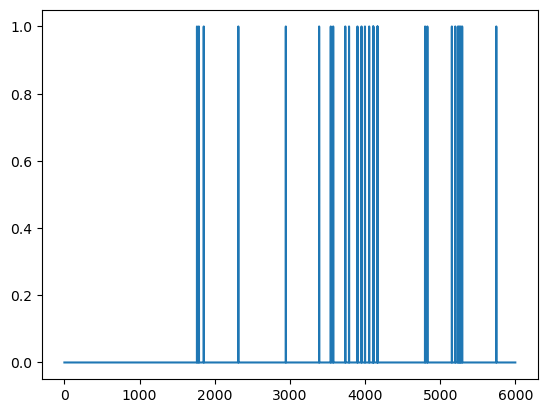

In [7]:
plt.plot(TEST_target)

In [8]:
IN = tf.keras.Input((128, 128, 19))

X = IN

X = k_layers.CONV_stack(X, 48, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack1')
X = tf.keras.layers.Conv2D(48, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv1')(X)

X = k_layers.CONV_stack(X, 96, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack2')
X = tf.keras.layers.Conv2D(96, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv2')(X)

X = k_layers.CONV_stack(X, 192, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack3')
X = tf.keras.layers.Conv2D(192, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv3')(X)

X = k_layers.CONV_stack(X, 384, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack4')
X = tf.keras.layers.Conv2D(384, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv4')(X)

D = tf.keras.layers.Flatten()(X)

D = tf.keras.layers.Dense(512, use_bias=False, name='dense1')(D)
D = tf.keras.layers.BatchNormalization(axis=-1, name='dense_bn1')(D)
D = GELU()(D)

D = tf.keras.layers.Dense(128, use_bias=False, name='dense2')(D)
D = tf.keras.layers.BatchNormalization(axis=-1, name='dense_bn2')(D)
D = GELU()(D)

D = tf.keras.layers.Dense(1, activation='sigmoid', name='head')(D)
#D = tf.keras.layers.Softmax()(D)

OUT = D

2022-09-02 19:40:52.610867: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-02 19:40:53.886490: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-02 19:40:53.929767: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:8a:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-09-02 19:40:53.930252: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-02 19:40:54.131599: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-09-02 19:40:54.132605: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [9]:
model = keras.models.Model(inputs=[IN,], outputs=[OUT,])

In [10]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience

epochs = 500
L_train = 64
batch_size = 100

batch_size_half = 50

valid_size = 1

In [11]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'VGG'

model_name = '{}_pp20'.format(key)
model_path = temp_dir+model_name

# W_new = model.get_weights()
# W_old = k_utils.dummy_loader(temp_dir+'VGG_X_pp20_tune2')

# for l in range(len(W_old)):
#     if W_old[l].shape == W_new[l].shape:
#         W_new[l] = W_old[l]
        
# model.set_weights(W_new)

model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(lr=2e-5))

In [12]:
X_batch = np.empty((batch_size, 128, 128, L_vars))
Y_batch = np.empty((batch_size, 1))
X_batch[...] = np.nan
Y_batch[...] = np.nan

In [13]:
#Y_pred = model.predict([VALID_X])
record = 1.0 #np.nanmean(np.abs(Y_pred-VALID_Y))
print("Initial record: {}".format(record))

Initial record: 1.0


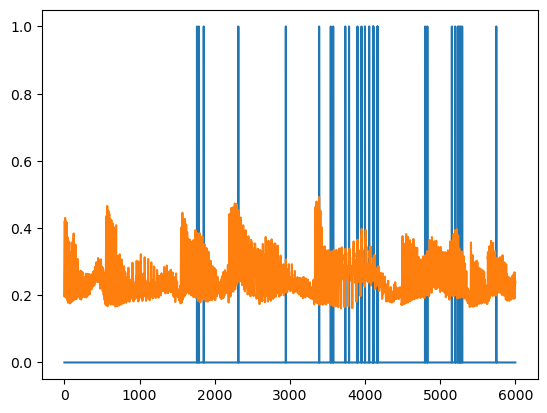

In [16]:
plt.plot(TEST_target)
plt.plot(Y_pred)

In [14]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
# ========== Training loop ========== #

N_aug = int(np.random.uniform(25, 50))
# N_wind = int(np.random.uniform(10, 15))
# N_hail = int(np.random.uniform(7, 13))
N_storm = 100 - N_aug


L_storm = len(filename_neg_storm)
#L_calm = len(filename_neg_calm)
# L_wind = len(filename_neg_wind)
# L_hail = len(filename_neg_hail)
L_aug = len(filename_aug)

for i in range(epochs):
    
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        ind_storm = du.shuffle_ind(L_storm)
        #ind_calm = du.shuffle_ind(L_calm)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_storm = []
        for ind_temp in ind_storm[:N_storm]:
            file_pick_storm.append(filename_neg_storm[ind_temp])
            
        # file_pick_calm = []
        # for ind_temp in ind_calm[:N_calm]:
        #     file_pick_calm.append(filename_neg_calm[ind_temp])
            
#         file_pick_wind = []
#         for ind_temp in ind_wind[:N_wind]:
#             file_pick_wind.append(filename_neg_wind[ind_temp])
            
#         file_pick_hail = []
#         for ind_temp in ind_hail[:N_hail]:
#             file_pick_hail.append(filename_neg_hail[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:N_aug]:
            file_pick_aug.append(filename_aug[ind_temp])
        
        file_pick = file_pick_storm + file_pick_aug #file_pick_calm + 
        
        if len(file_pick) != 100:
            sregwet
        
        for k in range(batch_size):
            
            data = np.load(file_pick[k])
            #for c, v in enumerate(ind_pick_from_batch):
            X_batch[k, ...] = data
            
            if 'pos' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.95, 0.99)
            elif 'neg' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.01, 0.05)
            else:
                werhgaer
                
        #Y_batch_cate = tf.keras.utils.to_categorical(Y_batch)
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([TEST_input,])
    # Y_pred[Y_pred<0] = 0
    # Y_pred[Y_pred>1] = 1
    #Y_pred = Y_pred[:, -1]
    record_temp = verif_metric(TEST_target, Y_pred, thres=0.5)
    
    # if i % 10 == 0:
    #     model.save(model_path_backup)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

2022-09-02 19:41:12.497889: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-02 19:41:12.604222: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2022-09-02 19:41:13.088703: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-09-02 19:41:13.753214: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


0.0 0.0 0.8155257959179528 0.0
Validation loss 1.0 NOT improved
0.0 0.0 0.818247837855681 0.0
Validation loss 1.0 NOT improved


KeyboardInterrupt: 

In [37]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

W_old = k_utils.dummy_loader(temp_dir+'VGG_ALL_pp20')
model.set_weights(W_old)

key = 'VGG_ALL'

model_name = '{}_pp20_tune'.format(key)
model_path = temp_dir+model_name

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=5e-6))

In [38]:
Y_pred = model.predict([TEST_input,])
record = verif_metric(TEST_target, Y_pred, thres=0.5)

0.11864406779661017 0.011340623734305387 0.9011255699708647 1.1290322580645162


In [39]:
record = verif_metric(TEST_target, Y_pred, thres=0.5)

0.11864406779661017 0.011340623734305387 0.9011255699708647 1.1290322580645162


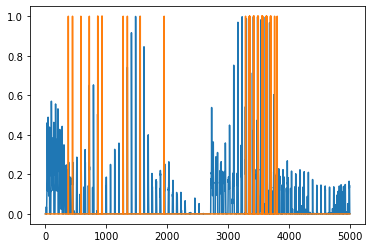

In [40]:
plt.plot(Y_pred.ravel())
plt.plot(TEST_target.ravel())

In [ ]:
# ========== Training loop ========== #

N_aug = int(np.random.uniform(10, 22))
# N_wind = int(np.random.uniform(10, 15))
# N_hail = int(np.random.uniform(7, 13))
N_storm = int(np.random.uniform(14, 32))
N_calm = 100 - N_aug - N_storm

L_storm = len(filename_neg_storm)
L_calm = len(filename_neg_calm)
# L_wind = len(filename_neg_wind)
# L_hail = len(filename_neg_hail)
L_aug = len(filename_aug)

for i in range(epochs):
    
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        ind_storm = du.shuffle_ind(L_storm)
        ind_calm = du.shuffle_ind(L_calm)
        # ind_wind = du.shuffle_ind(L_wind)
        # ind_hail = du.shuffle_ind(L_hail)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_storm = []
        for ind_temp in ind_storm[:N_storm]:
            file_pick_storm.append(filename_neg_storm[ind_temp])
            
        file_pick_calm = []
        for ind_temp in ind_calm[:N_calm]:
            file_pick_calm.append(filename_neg_calm[ind_temp])
            
#         file_pick_wind = []
#         for ind_temp in ind_wind[:N_wind]:
#             file_pick_wind.append(filename_neg_wind[ind_temp])
            
#         file_pick_hail = []
#         for ind_temp in ind_hail[:N_hail]:
#             file_pick_hail.append(filename_neg_hail[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:N_aug]:
            file_pick_aug.append(filename_aug[ind_temp])
        
        file_pick = file_pick_storm + file_pick_calm + file_pick_aug
        
        if len(file_pick) != 100:
            sregwet
        
        for k in range(batch_size):
            
            data = np.load(file_pick[k])
            #for c, v in enumerate(ind_pick_from_batch):
            X_batch[k, ...] = data
            
            if 'pos' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.95, 0.99)
            elif 'neg' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.01, 0.05)
            else:
                werhgaer
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([TEST_input,])
    record_temp = verif_metric(TEST_target, Y_pred, thres=0.5)
    
    # if i % 10 == 0:
    #     model.save(model_path_backup)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

0.08974358974358974 0.019036046982584043 0.8747827904728307 1.7419354838709677
Validation loss 0.8765922249793219 NOT improved
0.07317073170731707 0.020656136087484813 0.8842420204078967 1.8387096774193548
Validation loss 0.9092053501180174 NOT improved
0.08148148148148149 0.014783313082219522 0.8798978298645135 1.3548387096774193
Validation loss 0.8057825567502986 NOT improved
0.0963855421686747 0.021061158363710003 0.8881713897490168 1.935483870967742
Validation loss 0.9099883404586088 NOT improved
0.07291666666666667 0.00688537869582827 0.8882857105527899 0.6612903225806451
Validation loss 0.8094086021505377 NOT improved
0.11 0.007695423248278655 0.8938743647029618 0.7903225806451613
Validation loss 0.7539354838709679 NOT improved
0.08403361344537816 0.011543134872417983 0.890186702204105 1.0806451612903225
Validation loss 0.748902141501762 NOT improved
0.06451612903225806 0.006277845281490482 0.8922150798939102 0.5967741935483871
Validation loss 0.8290322580645163 NOT improved
0.12

In [50]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'TH_chad'
model_name = '{}_pp20'.format(key)
model_path = temp_dir+model_name

W = k_utils.dummy_loader(model_path)
model.set_weights(W)

### Classification results

In [9]:
from sklearn.metrics import classification_report, auc, roc_curve

In [53]:
#filename_train_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*TRAIN*.npy"))
#filename_train_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*TRAIN*.npy"))

filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))
filename_valid_neg = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_neg/*VALID*.npy"))

In [54]:
grid_shape = (128, 128)

label_pos = np.ones(len(filename_valid_pos))
label_neg = np.zeros(len(filename_valid_neg))
VALID_label = np.hstack([label_pos, label_neg])

L_valid = len(VALID_label)
L_vars = 20
L_sparse = len(flag_sparse)
L_dense = L_vars - L_sparse

VALID_sparse = np.empty((L_valid,)+grid_shape+(L_sparse,))
VALID_dense = np.empty((L_valid,)+grid_shape+(L_dense,))

for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
    data = np.load(filename)
    count0 = 0
    count1 = 0
    for v in range(L_vars):
        if v in flag_sparse:
            VALID_sparse[i, ..., count0] = data[..., v]
            count0 += 1
        else:
            VALID_dense[i, ..., count1] = data[..., v]
            count1 += 1

In [60]:
VALID_label

array([1., 1., 1., ..., 0., 0., 0.])

In [55]:
# filename_valid_pos = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*VALID*.npy"))[::10]
# label_pos = np.ones(len(filename_valid_pos))
# label_neg = np.zeros(len(filename_valid_neg))
# VALID_label_skew = np.hstack([label_pos, label_neg])

# L_valid = len(VALID_label_skew)

# VALID_skew = np.empty((L_valid,)+grid_shape+(5,))

# for i, filename in enumerate(filename_valid_pos+filename_valid_neg):
#     data = np.load(filename)
#     VALID_skew[i, ...] = data[...]

**Balanced verif**

In [56]:
Y_pred = model.predict([VALID_dense, VALID_sparse])
Y_pred_label = Y_pred > 0.5

2022-08-11 17:58:34.004253: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 47110422528 exceeds 10% of free system memory.


In [57]:
print(classification_report(Y_pred_label.ravel(), VALID_label.ravel()))

              precision    recall  f1-score   support

         0.0       1.00      0.53      0.69     55296
         1.0       0.00      0.00      0.00         0

    accuracy                           0.53     55296
   macro avg       0.50      0.27      0.35     55296
weighted avg       1.00      0.53      0.69     55296



/glade/work/ksha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/glade/work/ksha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/glade/work/ksha/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
print(classification_report(Y_pred_label.ravel(), VALID_label.ravel()))

              precision    recall  f1-score   support

       False       0.88      0.78      0.83     33142
        True       0.72      0.84      0.77     22154

    accuracy                           0.80     55296
   macro avg       0.80      0.81      0.80     55296
weighted avg       0.81      0.80      0.80     55296



In [58]:
fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
auc(fpr, tpr)

0.9319409017491813

In [17]:
fpr, tpr, thresholds = roc_curve(VALID_label.ravel(), Y_pred.ravel())
auc(fpr, tpr)

0.8871815021742365

In [18]:
fpr.shape

(17970,)

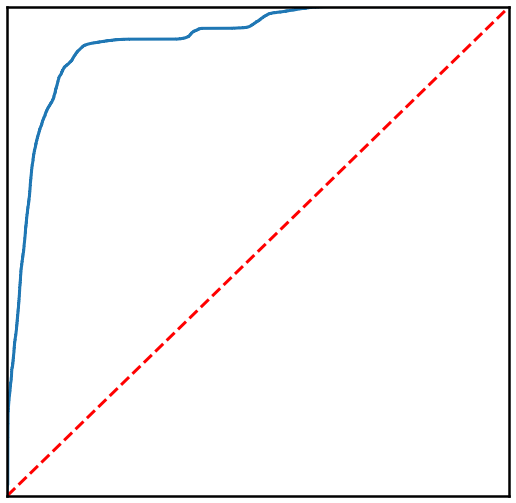

In [61]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()
ax = gu.ax_decorate_box(ax)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot(fpr, tpr, lw=3)
ax.plot(fpr, fpr, 'r--', lw=3)

**Natural verif**

In [25]:
Y_pred = model.predict([VALID_skew])
Y_pred_label = Y_pred > 0.5
print(classification_report(Y_pred_label.ravel(), VALID_label_skew.ravel()))

              precision    recall  f1-score   support

       False       0.88      0.97      0.92     26640
        True       0.67      0.33      0.44      5328

    accuracy                           0.86     31968
   macro avg       0.78      0.65      0.68     31968
weighted avg       0.84      0.86      0.84     31968



In [26]:
fpr, tpr, thresholds = roc_curve(VALID_label_skew.ravel(), Y_pred.ravel())
auc(fpr, tpr)

0.8685229089653266

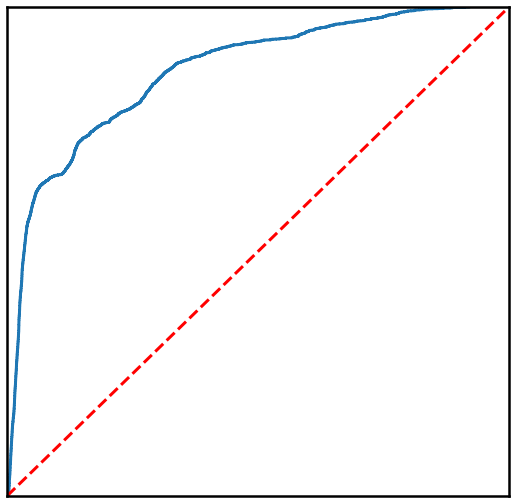

In [27]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()
ax = gu.ax_decorate_box(ax)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot(fpr, tpr, lw=3)
ax.plot(fpr, fpr, 'r--', lw=3)

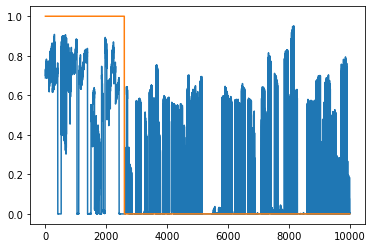

In [40]:
plt.plot(Y_pred.ravel()[:10000])
plt.plot(VALID_label_skew.ravel()[:10000])

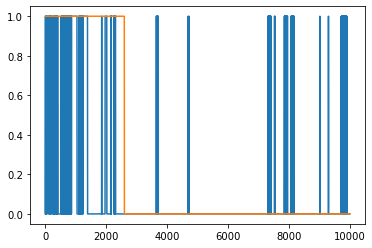

In [42]:
plt.plot(Y_pred.ravel()[:10000]>0.7)
plt.plot(VALID_label_skew.ravel()[:10000])